In [2]:
import os

import IPython
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchaudio

#set figure size for plots 
matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

#set the random seed for PyTorch's random number generator 
torch.random.manual_seed(0)
#checks if cuda-enabled GPU available 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(torchaudio.__version__)
print(device)

#url of speech audio file 
SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"  
#specify the local file path to save the audio file 
SPEECH_FILE = "_assets/speech.wav"

#if file doesn't exist, create the _assets directory, download/save audio file  
if not os.path.exists(SPEECH_FILE):
    os.makedirs("_assets", exist_ok=True)
    os.system(f"wget {SPEECH_URL} -O {SPEECH_FILE}")

2.2.1
2.2.1
cpu


In [3]:
#retrieve pre-trained Wav2Vec2 model with base architecture and 960h of training data 
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

#print sample rate of audio expected by model 
print("Sample Rate:", bundle.sample_rate)

#print labels used by model for transcription 
print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [4]:
#retrieve the model from bundle and moves to the specified device (GPU/CPU)
model = bundle.get_model().to(device)

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [5]:
IPython.display.Audio(SPEECH_FILE)

In [6]:
#load the audio file, return tensor containing audio waveform + int of audio sample rate 
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
#move the tensor to the device 
waveform = waveform.to(device)

#check if sample rate of audio different from sample rate expected by the model 
if sample_rate != bundle.sample_rate:
    #resample tensor to match expected sample rate 
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [16]:
#diable gradient calculation 
with torch.inference_mode():
    #features vector won't have gradients attached 
    features, _ = model.extract_features(waveform)

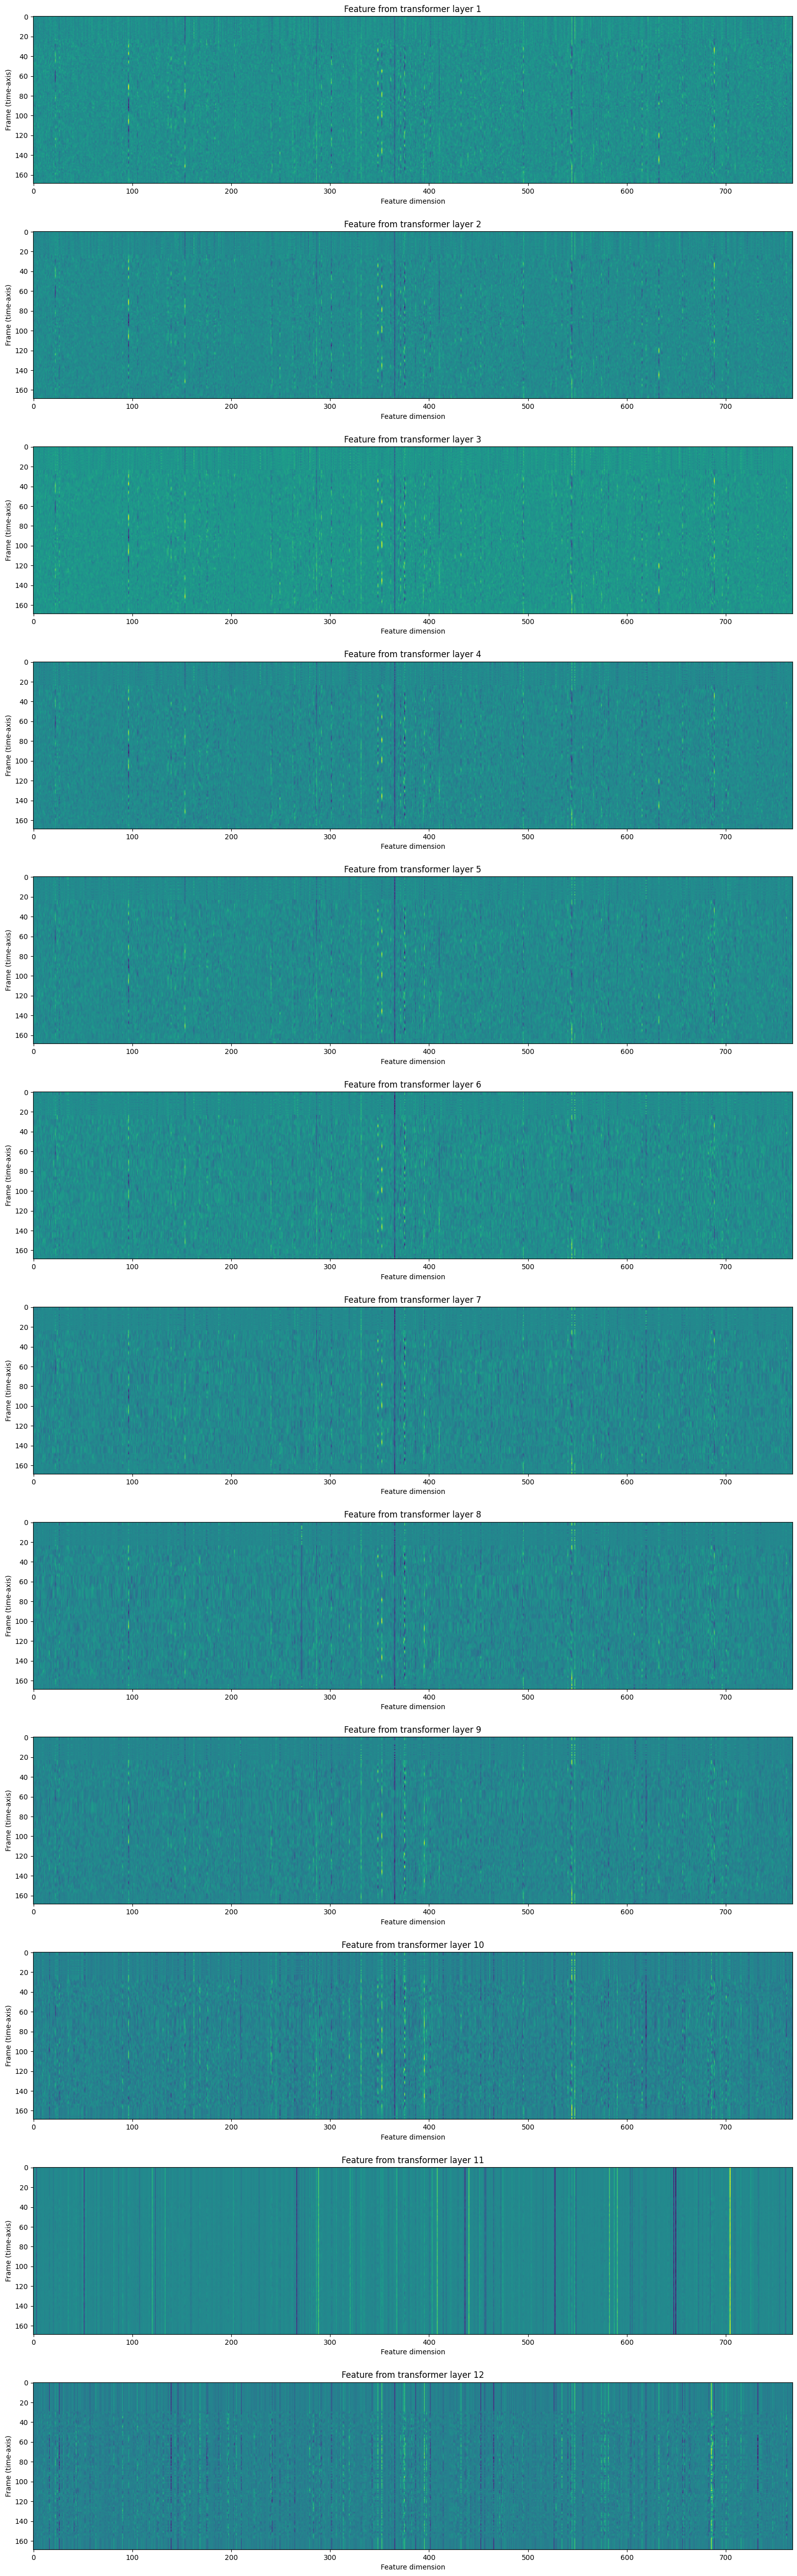

In [15]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
#iterate over features array - i is index of current feature and feats is actual feature tensor 
for i, feats in enumerate(features):
    #display tensor as an image on subplots 
    ax[i].imshow(feats[0].cpu())
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

In [9]:
with torch.inference_mode():
    #get the emission outputs - model's predictions 
    emission, _ = model(waveform)

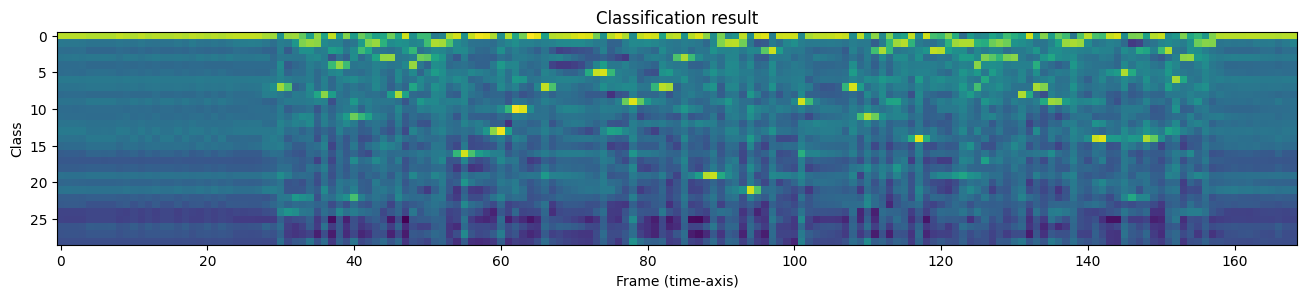

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [10]:
#each column is a different time step and each row is a different class 
plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

In [11]:
#decode output of a model trained with CTC 
class GreedyCTCDecoder(torch.nn.Module):
    #initialize with given labels (list of label strings) and blank symbol (index of blank symbol in label set) 
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        #find index of max values along last dimension of emission tensor 
        indices = torch.argmax(emission, dim=-1)  
        #remove duplicate indices 
        indices = torch.unique_consecutive(indices, dim=-1)
        #filters out blank symbol 
        indices = [i for i in indices if i != self.blank]
        #construct resulting transcript 
        return "".join([self.labels[i] for i in indices])

In [12]:
#labels from set of labels used in CTC model, then use decoder to decode emission tensor and get transcript
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [13]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|
